In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Part 1 Data Preprocessing

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Explation of Features:
Explation given by: @pcjimmmy, @sohier, @anshuls235, @awray3 , @panosc

Intersection : An intersection is an at-grade junction where two or more roads or streets meet or cross. Intersections may be classified by number of road segments, traffic controls, and/or lane design.

EntryStreetName : It is the street name where the traffic or vehicle entering the intersection.

ExitStreentName : It is the street name where the traffic or vehicel exiting the intersection.

EntryHeading and ExitHeading : Those are the directions the vehicle was traveling when entering/exiting the intersection. For example, you could see North/North if a truck just drove straight through without turning.

TotalTimeStopped_p20,_p40,_p50,_p60,_p80 : Let's focus on one row, say the one with RowId 2255742, 2255748. This row has the following percentiles for the Total Time Stopped feature:
比如
p20: 0

p40: 0

p50: 0

p60: 0

p80: 13

Of all the cars driving through the intersection, the first 60% didn't have to wait at all. The next 20% had to wait for 13 seconds and not sure about the next 20% as the data is not given for that.

DistanceToFirstStop: DistanceToFirstStop is how far before the intersection the truck stopped for the first time.

TimeFromFirstStop: TimeFromFirstStop is how long it took from that point to cross the intersection.

定义解释：
Intersection/EntryStreetName/ExitStreentName: 十字路口／进入路口街道名／驶出路口街道名

Entry／ExitHeading: 驶出朝向／驶出朝向：机动车进入／驶出路口的方向。比如：North/North指一辆卡车一直向北走没有转弯

TotalTimeStopped_p20,_p40,_p50,_p60,_p80：驶过路口的等待时间。比如对于RowID=2255742,2255748的路口，有p20=0,p40=0,p60=0,p80=13; 对于所有驶过路口的汽车，前20%，40%，50%，60%都不需要等待。60％－80%这部分车需要等待13秒，我们不清楚后20%因为数据没有给出。

In [4]:
#Funtion for Variable Description'''
def description(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [5]:
description(df_train)

Dataset Shape: (857409, 28)


Name   dtypes  Missing  Uniques  \
0                     RowId    int64        0   857409   
1            IntersectionId    int64        0     2539   
2                  Latitude  float64        0     4505   
3                 Longitude  float64        0     4541   
4           EntryStreetName   object     8189     1707   
5            ExitStreetName   object     5534     1693   
6              EntryHeading   object        0        8   
7               ExitHeading   object        0        8   
8                      Hour    int64        0       24   
9                   Weekend    int64        0        2   
10                    Month    int64        0        9   
11                     Path   object        0    15111   
12     TotalTimeStopped_p20    int64        0      172   
13     TotalTimeStopped_p40    int64        0      234   
14     TotalTimeStopped_p50    int64        0      264   
15     TotalTimeStopped_p60    int64        0      311   
16     TotalTimeStopped_p80    int64        0      403   
17    TimeFromFirstStop_p20    int64        0      239   
18    TimeFromFirstStop_p40    int64        0      306   
19    TimeFromFirstStop_p50    int64        0      329   
20    TimeFromFirstStop_p60    int64        0      351   
21    TimeFromFirstStop_p80    int64        0      355   
22  DistanceToFirstStop_p20  float64        0     3479   
23  DistanceToFirstStop_p40  float64        0     6257   
24  DistanceToFirstStop_p50  float64        0     7483   
25  DistanceToFirstStop_p60  float64        0     9495   
26  DistanceToFirstStop_p80  float64        0    13267   
27                     City   object        0        4   

                                          First Value  \
0                                             1920335   
1                                                   0   
2                                             33.7917   
3                                              -84.43   
4                        Marietta Boulevard Northwest   
5                        Marietta Boulevard Northwest   
6                                                  NW   
7                                                  NW   
8                                                   0   
9                                                   0   
10                                                  6   
11  Marietta Boulevard Northwest_NW_Marietta Boule...   
12                                                  0   
13                                                  0   
14                                                  0   
15                                                  0   
16                                                  0   
17                                                  0   
18                                                  0   
19                                                  0   
20                                                  0   
21                                                  0   
22                                                  0   
23                                                  0   
24                                                  0   
25                                                  0   
26                                                  0   
27                                            Atlanta   

                                         Second Value  \
0                                             1920336   
1                                                   0   
2                                             33.7917   
3                                              -84.43   
4                        Marietta Boulevard Northwest   
5                        Marietta Boulevard Northwest   
6                                                  SE   
7                                                  SE   
8                                                   0   
9                                                   0   
10                                                  6   
11

In [6]:
description(df_test)

Dataset Shape: (1920335, 13)


Name   dtypes  Missing  Uniques  \
0             RowId    int64        0  1920335   
1    IntersectionId    int64        0     2768   
2          Latitude  float64        0     5613   
3         Longitude  float64        0     5614   
4   EntryStreetName   object    19157     2136   
5    ExitStreetName   object    16340     2117   
6      EntryHeading   object        0        8   
7       ExitHeading   object        0        8   
8              Hour    int64        0       24   
9           Weekend    int64        0        2   
10            Month    int64        0        9   
11             Path   object        0    19855   
12             City   object        0        4   

                                          First Value  \
0                                                   0   
1                                                   1   
2                                             33.7509   
3                                             -84.393   
4                          Peachtree Street Southwest   
5                           Mitchell Street Southwest   
6                                                  SW   
7                                                  SE   
8                                                   0   
9                                                   0   
10                                                  6   
11  Peachtree Street Southwest_SW_Mitchell Street ...   
12                                            Atlanta   

                                         Second Value  \
0                                                   1   
1                                                   1   
2                                             33.7509   
3                                             -84.393   
4                          Peachtree Street Southwest   
5                          Peachtree Street Southwest   
6                                                  SW   
7                                                  SW   
8                                                   0   
9                                                   0   
10                                                  6   
11  Peachtree Street Southwest_SW_Peachtree Street...   
12                                            Atlanta   

                                          Third Value  Entropy  
0                                                   2    20.87  
1                                                   1    10.85  
2                                             33.7509    11.84  
3                                             -84.393    11.86  
4                          Peachtree Street Southwest     9.19  
5                          Peachtree Street Southwest     9.17  
6                                                  NE     2.90  
7                                                  NE     2.90  
8                                                   1     4.49  
9                                                   0     0.84  
10                                                  6     2.81  
11  Peachtree Street Southwest_NE_Peachtree Street...    11.98  
12                                            Atlanta     1.85

The columns with missing data are the same in both train and test sets: EntryStreetName and ExitStreetName. It seems that most columns are without any missing data after calculating the 0.01 Proportion missing. And those that do have only a small proportion missing, so it should be safe to simply remove those observations prior to model fitting.

在训练和测试集中，数据缺失的列相同：EntryStreetName和ExitStreetName。在计算丢失的数据仅占1%比例后，我们发现大多数列似乎没有任何丢失的数据。而且这两列只丢失了很小一部分的数据，因此在模型拟合之前可以直接删除这些观测值。

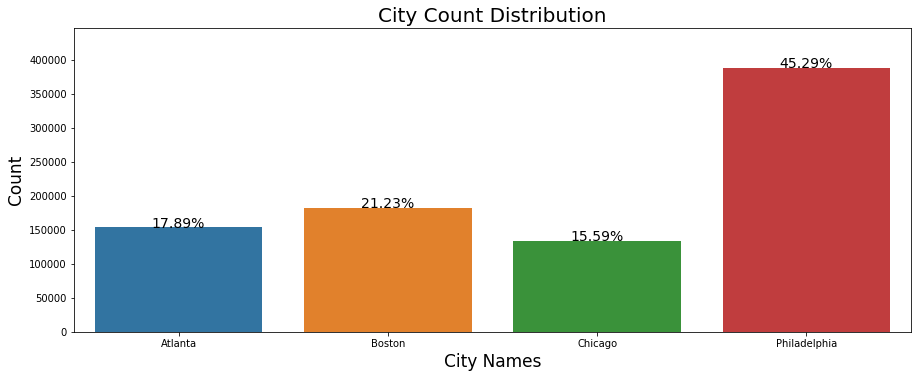

In [7]:
#visualize city distribution
total = len(df_train)
plt.figure(figsize=(15,19))

plt.subplot(311)
g = sns.countplot(x="City", data=df_train)
g.set_title("City Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("City Names", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

Findings: In the city count distribution:

Philadelphia have 45.29% of the total entries followed by Boston(21.23%), Atlanta(17.89%), Chicago(15.59%)

观察数据集数据分布，费城的数据最多，为45.29%， 剩下三个城市的数据量差别不大，对我们的预测不会有较大影响。

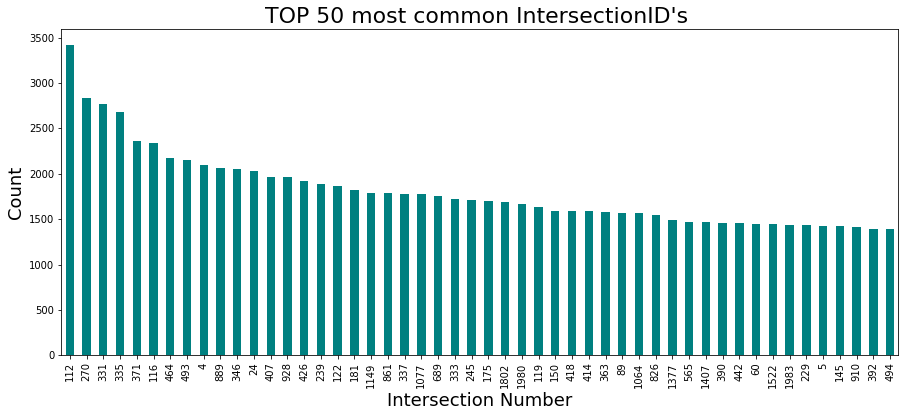

In [8]:
#Explorationary Data Anaysis
#1.Intersection Number
plt.figure(figsize=(15,6))
df_train.IntersectionId.value_counts()[:50].plot(kind='bar', color = 'teal')
plt.xlabel("Intersection Number", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("TOP 50 most common IntersectionID's ", fontsize=22)
plt.show()

112 is the most common IntersectionID

出现次数最多的交叉路口ID是112 （我觉得这里就是为了可视化而可视化，ppt里可以不放）

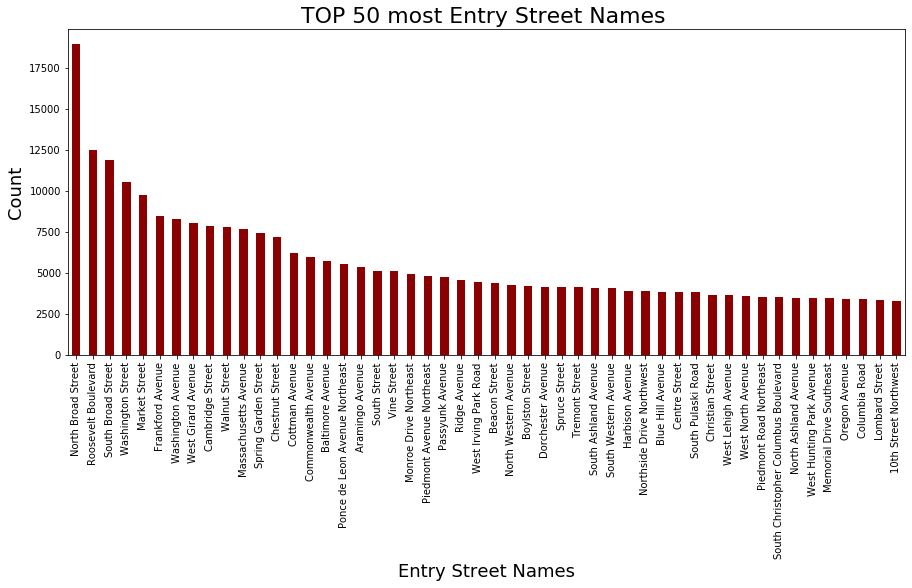

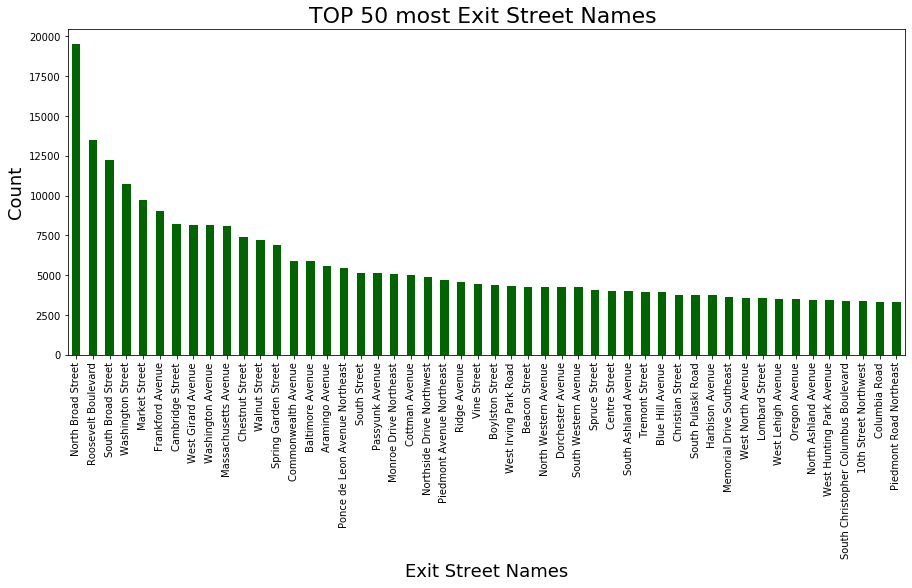

In [9]:
#2. Entry/Exit Street Paths
plt.figure(figsize=(15,6))
df_train['EntryStreetName'].value_counts()[:50].plot(kind='bar', color = 'darkred')
plt.xlabel("Entry Street Names", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("TOP 50 most Entry Street Names ", fontsize=22)
plt.show()

plt.figure(figsize=(15,6))
df_train['ExitStreetName'].value_counts()[:50].plot(kind='bar', color = 'darkgreen')
plt.xlabel("Exit Street Names", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("TOP 50 most Exit Street Names ", fontsize=22)
plt.show()

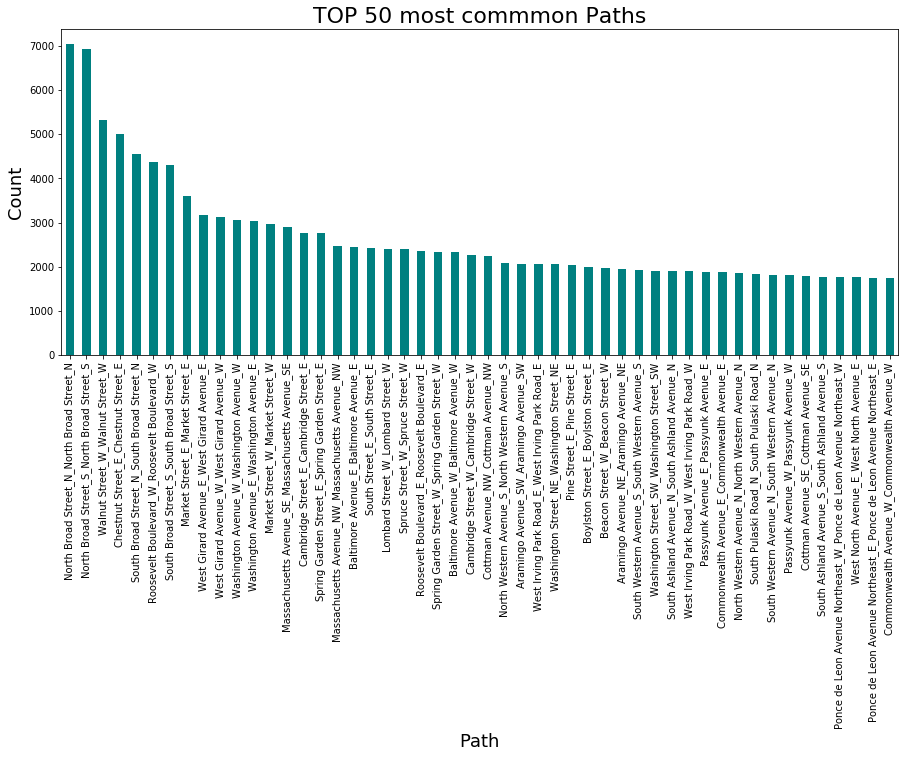

In [10]:
#3.Path
#Visulization of Path
plt.figure(figsize=(15,6))
df_train.Path.value_counts()[:50].plot(kind='bar', color = 'teal')
plt.xlabel("Path", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("TOP 50 most commmon Paths", fontsize=22)
plt.show()

North Broad Street is the most Entry and Exit Street Names.
这三张表可以一起分析。对于通行量给我们很多insights
1）最频繁出现的街道是North Broad Street，在三张表中都是数据量最多的街道
2）注意到25名以后的街道数据量基本持平
3）以及绝大多数车辆都保持直行

In [11]:
#3 Time Distribution (by month and by daytime)
tmp_hour = df_train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()

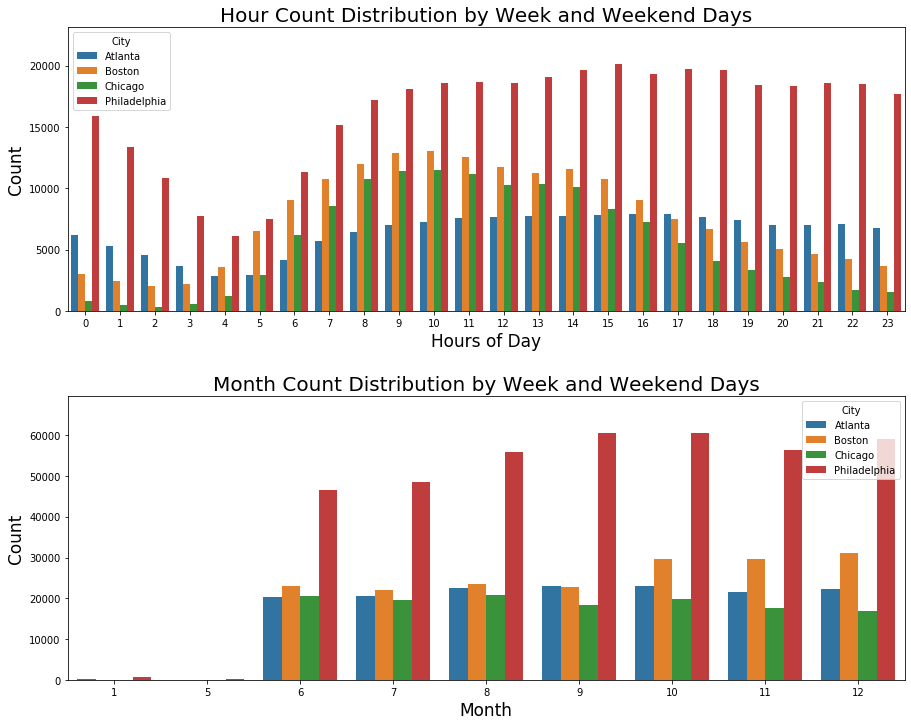

In [12]:
plt.figure(figsize=(15,12))

plt.subplot(211)
g = sns.countplot(x="Hour", data=df_train, hue='City', dodge=True)
g.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="Month", data=df_train, hue='City', dodge=True)
g1.set_title("Month Count Distribution by Week and Weekend Days", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Month", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

In the hours chart:

We can see that cities can have different hours patterns.
Philadelphia is by far the most common in all hours. Only on 5 a.m that is almost lose to Boston in total entries. 
Between 08:00 to 17:00, is the rush hour in all cities, but for Philadelphia, it is 08:00 to 24:00.
Atlanta is the city with less entries in all day, but after 17 p.m to 4a.m it's the second city with more rides

In the month chart:

We can note that the data is about only 6 months (with few values in January and May)
Also, the pattern of the Boston City improved througout the time and the others seem very unchanged.
Now, let's explore the Entry and Exit features.

在小时图中：

我们可以看到城市可以有不同的时间模式。
1）费城在所有时段中都拥有最高的数据量。仅在凌晨5点，通行数据小于波士顿。
2）所有城市的高峰时间为08:00至17:00，但费城为08:00至24:00。
3）亚特兰大白天的通行量没有明显的波峰波谷，但从下午17点至凌晨4点，这是第二个汽车通行数据较多的城市，分布较为平均

在月份图中：

我们可以注意到，数据大约只有6个月（一月和五月的值很少）
同样，波士顿市的通行数据随月份增大而增大，其他城市的通行数据基本保持不变。

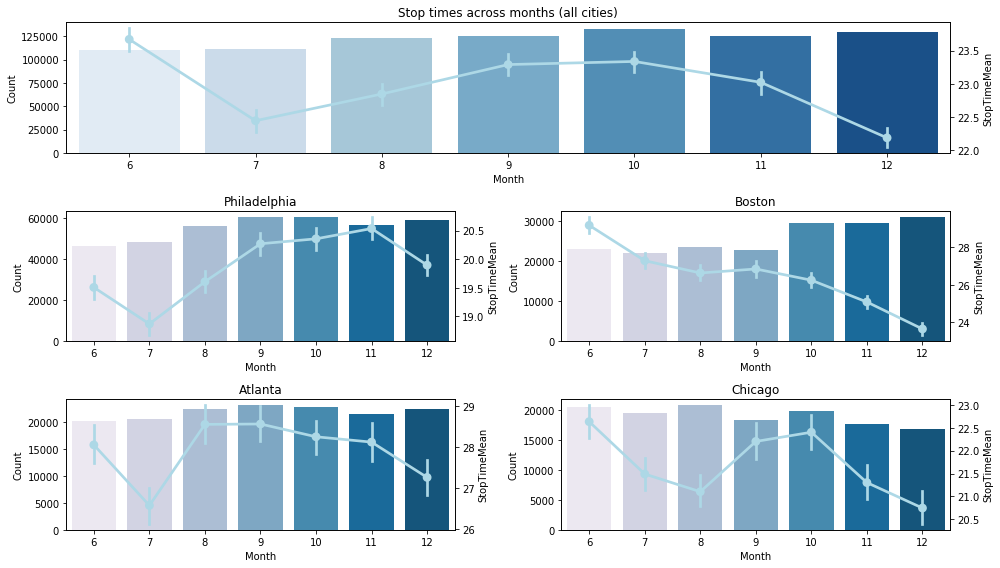

In [13]:
trainP = df_train.loc[df_train['City'] == 'Philadelphia']
trainB = df_train.loc[df_train['City'] == 'Boston']
trainA = df_train.loc[df_train['City'] == 'Atlanta']
trainC = df_train.loc[df_train['City'] == 'Chicago']

f = plt.figure(figsize = (14,8))
s = plt.subplot2grid((3,2),(0,0), 1, 3,f)
p = plt.subplot2grid((3,2),(1,0), 1, 1,f)
b = plt.subplot2grid((3,2),(1,1), 1, 1,f)
a = plt.subplot2grid((3,2),(2,0), 1, 1,f)
c = plt.subplot2grid((3,2),(2,1), 1, 1,f)

m=sns.countplot(x = 'Month', data = df_train[df_train['Month'].isin([6,7,8,9,10,11,12])], 
                palette = 'Blues', ax = s)
at = s.twinx()
point = sns.pointplot(x='Month', y='TotalTimeStopped_p80', data = df_train[df_train['Month'].isin([6,7,8,9,10,11,12])], 
                   color = 'lightblue', ax = at )
m.set_title('Stop times across months (all cities)')
m.set_ylabel('Count')
point.set_ylabel('StopTimeMean')
#####
temp = [[trainP,trainB,trainA,trainC],
        [p,b,a,c],
        ['Philadelphia', 'Boston', 'Atlanta', 'Chicago']]
for i in range(0,4):
    
    count = sns.countplot(x = 'Month', data = temp[0][i][temp[0][i]['Month'].isin([6,7,8,9,10,11,12])], 
                   palette = 'PuBu', ax = temp[1][i])
    count.set_title(temp[2][i])
    count.set_ylabel('Count')
    at = temp[1][i].twinx()
    point = sns.pointplot(x='Month', y='TotalTimeStopped_p80', data = temp[0][i][temp[0][i]['Month'].isin([6,7,8,9,10,11,12])],
                      color = 'lightblue', ax = at )
    
    point.set_ylabel('StopTimeMean')


plt.tight_layout()

Viewing the relationship between month and stop times for all cities, a minimum for the stop time can be seen in the data for July, after which the average stop time climbs upwards reaching a maximum at around October and starts to decrease once again towards the months of November and December. My guess is that as summer time approaches, a significant portion of people take breaks from work and maybe go on vacation, which would explain the minimum at July. And similar reasoning should also apply as we approach the holiday months near the end of the year, as evidenced by the second dip in stop times. The same general trend can be seen if we observe each of the cities individually, with some variance in where the minimum and maximum are for these specific cases. An indirect effect of season/monthly times on average stop time is thus observed. Direct effects of climate on traffic seem impossible to isolate from the given data alone.

通过这两张表可以探究所有城市的月份和在路口等待时间的关系。7月份的数据中看到最小堵车时间，此后，平均等待时间逐渐变长，在10月左右达到最大值，然后开始逐渐向几个月减小11月和12月。

我们的猜测是，随着夏季时间的临近，很大一部分人会在家休息，也许会去度假，这可以解释7月份的最短时间。随着临近年底的假期，类似的推理也应适用，因为等待时间第二次出现下降。

如果我们分别观察每个城市，则可以看到相同的总体趋势，在这些特定情况下，最大和最小的位置有所不同。因此观察到季节/月份对平均停止时间的间接影响，气候对交通的直接影响似乎不可能仅从给定的数据中分离出来。

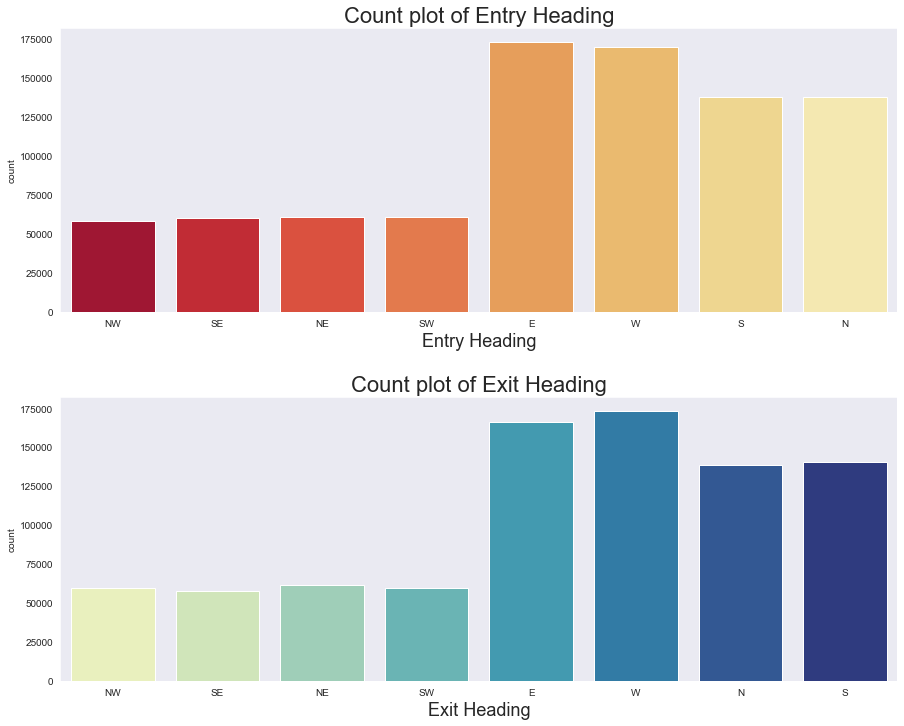

In [14]:
#4.Entry/Exit Heading
sns.set_style("dark")
fig, ax = plt.subplots(2,1, figsize=[15, 12])

sns.countplot(data = df_train, x = 'EntryHeading', ax = ax[0], palette = 'YlOrRd_r')
ax[0].set_title('Count plot of Entry Heading', fontsize = 22)
ax[0].set_xlabel('Entry Heading', fontsize = 18)

sns.countplot(data = df_train, x = 'ExitHeading', ax = ax[1], palette = 'YlGnBu')
ax[1].set_title('Count plot of Exit Heading', fontsize = 22)
ax[1].set_xlabel('Exit Heading', fontsize = 18)

plt.subplots_adjust(hspace = 0.3)
plt.show()

We can find that the Entry Heading and the Exite HEad share similar pattern with east and west being two direction most popular among all.
With this insight, I would further ask, is this similarity due to same heading for exit and entry? And will the change of direction influence the waiting time?


我们可以发现，车辆驶入驶出的方向具有相似的数据量，东西两个方向是最受欢迎的两个方向。
我们将进一步探究，这种数据的相似性是由于车辆出入的方向相同还是驶入驶出基本相似呢？或者说，方向变化会影响等待时间吗？

Text(0.5, 1.0, 'Counts of all entry-exit combinations')

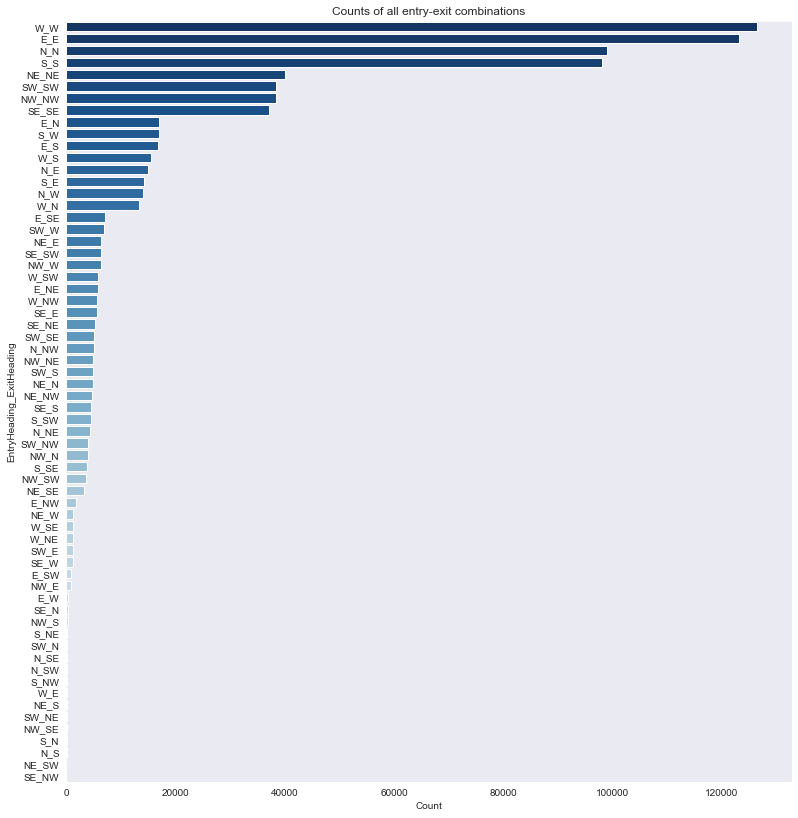

In [15]:
#combine entry heading and exit heading
df_train['pathDirectionOnly'] = df_train['EntryHeading'] + '_' + df_train['ExitHeading']

pathd = pd.DataFrame({'EntryHeading_ExitHeading': df_train['pathDirectionOnly'].value_counts().index, 
                      'Count': df_train['pathDirectionOnly'].value_counts()})

f4, axes4 = plt.subplots( figsize=(13, 14))
sns.barplot(x='Count', y='EntryHeading_ExitHeading', data = pathd, ax = axes4, palette='Blues_r')
axes4.set_title('Counts of all entry-exit combinations')

There are a total of 64 entry-exit combinations. The result show that most cars don't change heading direction for entry and exit. The most frequent ones involve no turning (i.e. East -> East: 0 degrees), the next most frequent are simple right/left turns (i.e. East ->North: 90 degrees), followed by turns of abnormal angles (i.e. Northwest -> West: 45 degrees). It may be more informative to convert these 64 entry-exit combinations into the 5 possible angles associated with a turn (0, 45, 90, 135, 180), and check how this feature compares with stop time. 

共有64种驶入驶出方向的组合。结果表明，大多数汽车不会改变进出方向。最常见的是不转弯（即，东->东：0度），其次最常见的是简单的左右转弯（即，东->北：90度），然后是异常角度的转弯（即，西北->西：45度），还有掉头（180度）。将这64个进出方向的组合转换为与转弯（0、45、90、135、180）的5个可能的角度，并探究此转弯角度与停止时间两者之间的关系。

In [16]:
#Define function to get angle between 'EntryHeading' and 'ExitHeading'
def getAngleOfTurn(df):
        compassAngle = {'N':0, 'NE':45, 'E':90, 'SE':135, 'S':180, 
                        'SW':225, 'W':270, 'NW':315 }
        a = df['EntryHeading'] 
        b = df['ExitHeading']
        angle = abs(compassAngle[a] - compassAngle[b])
        if angle < 225:
            return angle
        elif angle == 225:
            return 135
        elif angle == 270:
            return 90
        elif angle == 315:
            return 45        
df_train['angleOfTurn'] = df_train.apply(getAngleOfTurn, axis=1)


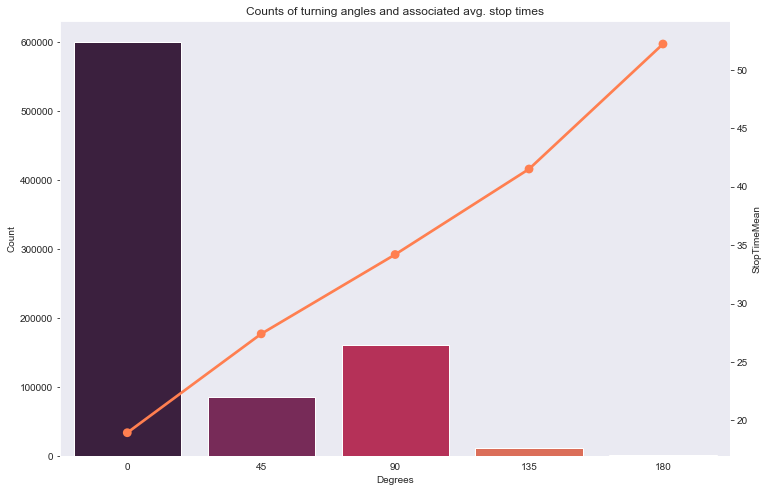

In [17]:
anglesDf = pd.DataFrame({'angleOfTurn': df_train.groupby('angleOfTurn')['TotalTimeStopped_p80'].agg('mean').index,
                         'Count': df_train.groupby('angleOfTurn')['angleOfTurn'].agg('count'),
                         'StopTimeMean' : df_train.groupby('angleOfTurn')['TotalTimeStopped_p80'].agg('mean')})

f5, axes5 = plt.subplots( figsize=(12, 8))

dircount = sns.barplot(x='angleOfTurn', y='Count' , data = anglesDf, palette = 'rocket', ax = axes5)
dircount.set_title('Counts of turning angles and associated avg. stop times')
dircount.set_ylabel('Count')
dircount.set_xlabel('Degrees')

a = axes5.twinx()
sns.pointplot(x = 'angleOfTurn', y = 'StopTimeMean', color = 'coral',data = anglesDf, ax = a)

The frequency of each turn angle is consistent with our previous investigation of 'isSameDirection' - turns of 0 degrees count for around 0.70 of all turns, and frequencies of all other turn angles (45, 90, 135, and 180) sum to roughly 0.30. Plotting the average 80th percentile of TotalTimeStopped (abbreviated as StopTimeMean) for each of the angle groups on the same axis reveals a linear relationship between the magnitude of the angle turned and the time stopped. Interestingly, there are even some drivers that made complete U-turns of 180 degrees at the intersection, going back the way they came. Unsurprisingly, these turned out to have the highest average stop time. 'angleOfTurn' should be a feature worth keeping

我们可以看出每个转角的频率：0度转数计数为所有转数的0.70，所有其他转角的频率（45、90、135和180）的总和约为0.30 。

在同一轴上为每个角度组绘制TotalTimeStopped（缩写为StopTimeMean）的平均第80个百分位数，显示转过的角度的大小与等待时间之间存在线性关系，转角越大，等待时间越长。所以掉头时间最长。 “angleOfTurn”应该是一个值得保留的数据值。

In [18]:
#Latitude/Longitude
import mplleaflet
plt.figure(figsize=(10,10))
map1 = df_train[df_train['City']=='Atlanta'].groupby(['Latitude', 'Longitude'])['RowId'].count().reset_index()
plt.scatter(map1['Longitude'], map1['Latitude'], alpha=0.5)

mplleaflet.display()

D:\python_anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [19]:
plt.figure(figsize=(10,10))
map2 = df_train[df_train['City']=='Boston'].groupby(['Latitude', 'Longitude'])['RowId'].count().reset_index()
plt.scatter(map2['Longitude'], map2['Latitude'], alpha=0.5)

mplleaflet.display()

D:\python_anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [20]:
plt.figure(figsize=(10,10))
map3 = df_train[df_train['City']=='Philadelphia'].groupby(['Latitude', 'Longitude'])['RowId'].count().reset_index()
plt.scatter(map3['Longitude'], map3['Latitude'], alpha=0.5)

mplleaflet.display()

D:\python_anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [21]:
plt.figure(figsize=[10, 10])
map4 = df_train[df_train['City']=='Chicago'].groupby(['Latitude', 'Longitude'])['RowId'].count().reset_index()
sns.kdeplot(map4['Longitude'], map4['Latitude'])

mplleaflet.display()

D:\python_anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Day/Night and weather affect traffics. We can Add temperature and rainfall of the cities.
Urban locations: likely if a street is numbered but Rural locations are not, may affect the traffic.
The intersection is surrounded by businesses: may affect the traffic during weeks and weekend day.

从这4幅图我们可以发现一些共性：
1）白天/夜晚和天气会影响流量。我们可以添加城市的温度和降雨量来进一步研究。
2）我们的数据主要集中在市区：因为乡村的编号较少且稀疏。
3）交叉路口周围是商圈可能会在周中和周末影响交通。
4）每个城市的集中度和地形也有关，如果再给出一些数据值可以进一步探究。

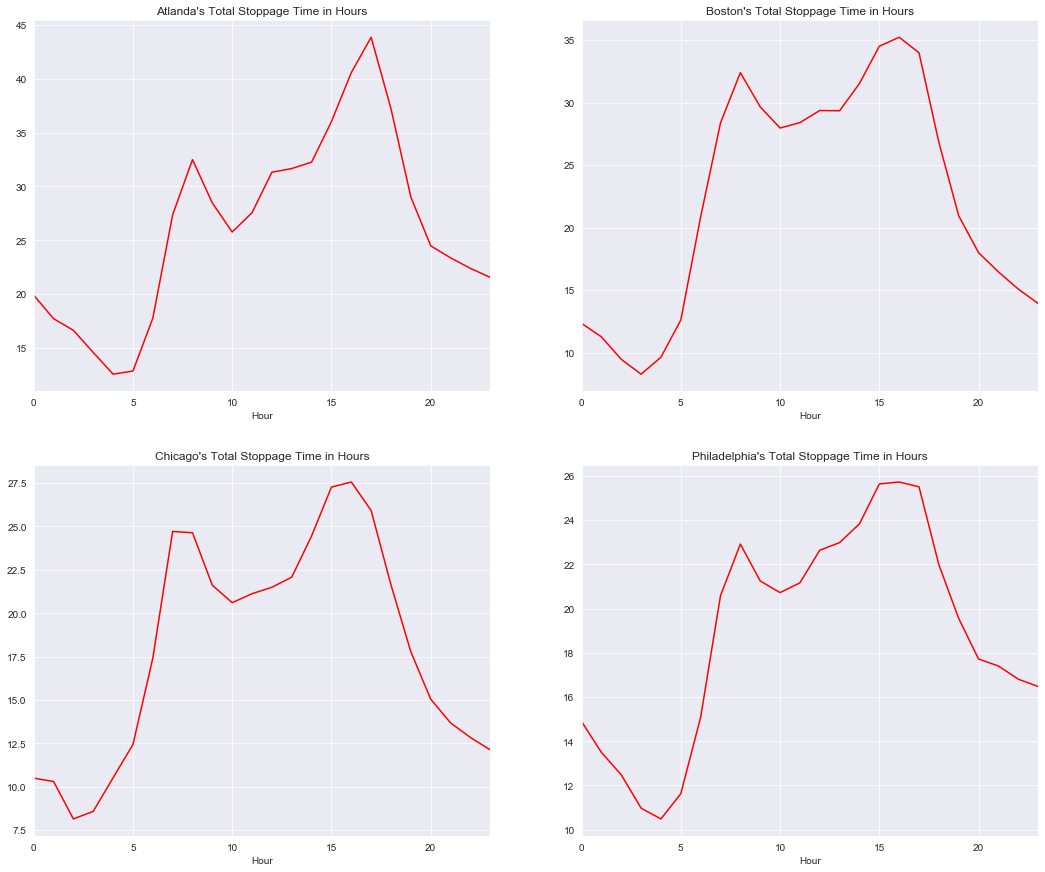

In [22]:
#Total Time Spent
fig, ax = plt.subplots(nrows=2, ncols=2)
sns.set_style("whitegrid")

df_train[df_train['City']=='Atlanta'].groupby('Hour')['TotalTimeStopped_p80'].mean().plot(
    ax=ax[0,0],title="Atlanda's Total Stoppage Time in Hours", color='r', figsize=(18,15))

df_train[df_train['City']=='Boston'].groupby('Hour')['TotalTimeStopped_p80'].mean().plot(
    ax=ax[0,1],title="Boston's Total Stoppage Time in Hours", color='r', figsize=(18,15))


df_train[df_train['City']=='Chicago'].groupby('Hour')['TotalTimeStopped_p80'].mean().plot(
    ax=ax[1,0],title="Chicago's Total Stoppage Time in Hours", color='r', figsize=(18,15))


df_train[df_train['City']=='Philadelphia'].groupby('Hour')['TotalTimeStopped_p80'].mean().plot(
    ax=ax[1,1],title="Philadelphia's Total Stoppage Time in Hours", color='r', figsize=(18,15))

plt.show()

之前研究过通行车辆数的时间分布，现在来看等待时间和时间分布的关系。
可以发现一些普遍的堵车规律：早晚高峰分别出现在：早8:00--9:00和晚上15:00-17:00 和中国不太相同hhh 下班好早羡慕了）
晚高峰都比早高峰更堵一点。

Exploring numerical features
According to the competition description, these are the target features:
本次实验预测的数据为：
TotalTimeStopped_p20

TotalTimeStopped_p50

TotalTimeStopped_p80

DistanceToFirstStop_p20

DistanceToFirstStop_p50

DistanceToFirstStop_p80

TimeFromFirstStop_p20

TimeFromFirstStop_p50

TimeFromFirstStop_p80

In [23]:
t_stopped = ['TotalTimeStopped_p20',
             'TotalTimeStopped_p50', 
             'TotalTimeStopped_p80']
t_first_stopped = ['TimeFromFirstStop_p20',
                   'TimeFromFirstStop_p50',
                   'TimeFromFirstStop_p80']
d_first_stopped = ['DistanceToFirstStop_p20',
                   'DistanceToFirstStop_p50',
                   'DistanceToFirstStop_p80']

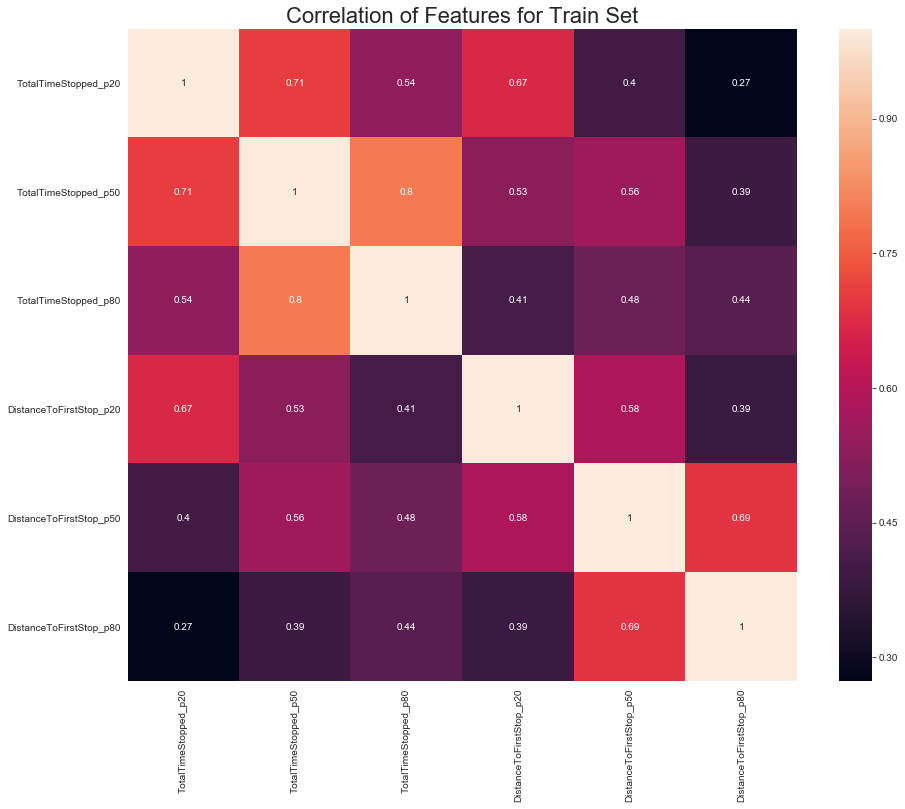

In [24]:
plt.figure(figsize=(15,12))
plt.title('Correlation of Features for Train Set', fontsize=22)
sns.heatmap(df_train[t_stopped + 
                     #t_first_stopped + 
                     d_first_stopped].astype(float).corr(),
            vmax=1.0,  annot=True)
plt.show()

We can see that the best correlation between the metrics are:
Distance to First Stop p20 and Total Time Stopped p20 have a high correlation.

从heatmap中我们可以读出：
20%第一次停车的距离和20%总时长有强相关关系。

In [25]:
#DATA PREPROCESSING

from sklearn.preprocessing import minmax_scale

target_cols = t_stopped + d_first_stopped

#这里我不是特别懂为什么需要这两个figure相加
#又理解了一下是求整个全程的时间 也就是从停车点到intersaction＋驶过intersaction的全程

In [26]:
for col in target_cols:
    df_train[col+str("_minmax")] = (minmax_scale(df_train[col], feature_range=(0,1)))
    
min_max_cols = ['TotalTimeStopped_p20_minmax', 'TotalTimeStopped_p50_minmax',
                'TotalTimeStopped_p80_minmax', 'DistanceToFirstStop_p20_minmax',
                'DistanceToFirstStop_p50_minmax', 'DistanceToFirstStop_p80_minmax']

（reference: https://www.kaggle.com/vikassingh1996/thoughtful-eda-feature-engineering-and-lightgbm#1.-Importing-Packages-and-Collecting-Data
https://www.kaggle.com/kabure/insightful-eda-modeling-lgbm-hyperopt#Objective
https://www.kaggle.com/microfarads/descriptive-eda-visuals）

# Part 2 PCA Clustering

找到关键因素，pca降维，添加至训练集表格中
他这里用pca对target降维而不是feature
确实很瞎，但是explore嘛 都是瞎着来的

In [1]:
pca = PCA(n_components = 0.9, random_state = 5)
#找到pca可解释比例高达0.9的target
principalComponents = pca.fit_transform(df_train[min_max_cols])
#print(principalComponents)
principalDf = pd.DataFrame(principalComponents)
#print(principalDf)
prefix = 'Target_PCA'
principalDf.rename(columns = lambda x: 
                   str(prefix)+str(x), inplace = True)

df_train = pd.concat([df_train,principalDf], axis = 1)


NameError: name 'PCA' is not defined

In [ ]:
pca.explained_variance_ratio_[].sum()
#选择的数据列能够解释90%的差异来源，
#算是包含了大部分的信息，
#可以用作对这么多（六列）的target的一个代表

PCA画散点图  
这里还属于EDA的范围 他就是自由的探索  
对target降维可以理解是 想要知道最后得到的结果到底在工作日和周末、不同城市有着什么样的不同

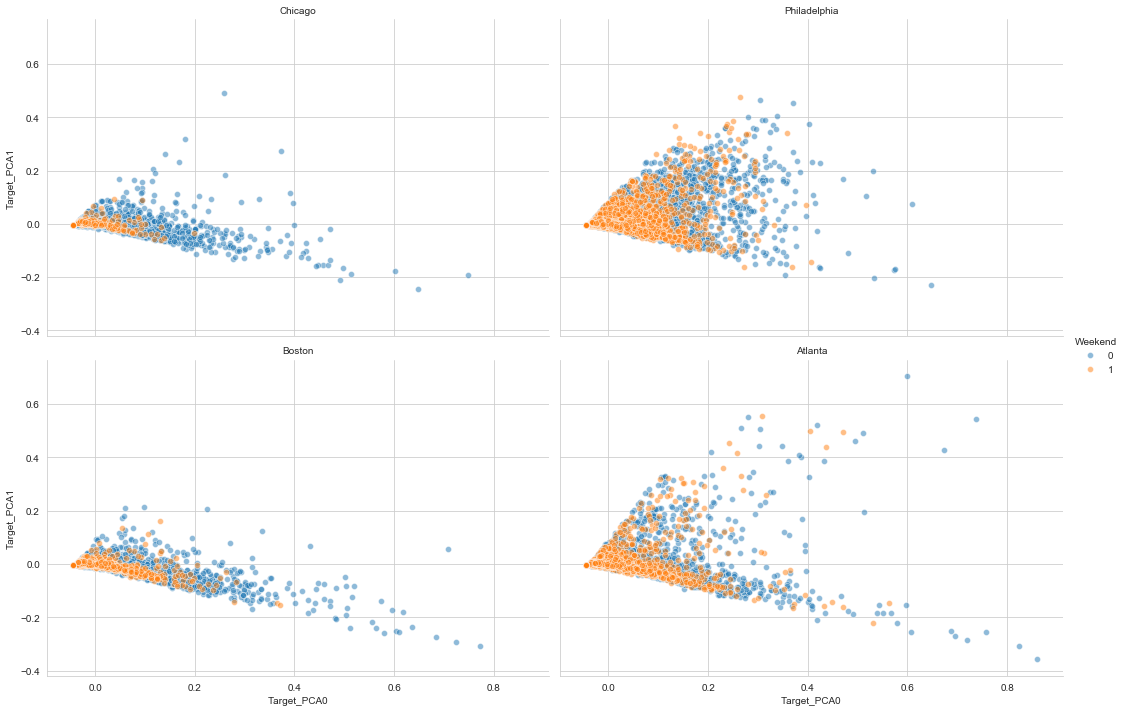

In [29]:
g = sns.FacetGrid(df_train.sample(50000), col="City", 
                  col_wrap=2, height=5, aspect=1.5, hue='Weekend')

g.map(sns.scatterplot, "Target_PCA0", "Target_PCA1", alpha=.5 ).add_legend();
g.set_titles('{col_name}', fontsize=17)
plt.show()

#### 进入一个新方法

从这里开始，进行另外一个探索-kmeans
首先是对所有的target进行一个无监督的聚类  
聚多少类呢？这里就先套了一个肘部法则

In [30]:
#sum of squared distances
ssd = []

K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=4)
    km = km.fit(df_train[min_max_cols])
    ssd.append(km.inertia_) #返回样本到聚类中心的平方和
    
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

plt.show()

KeyboardInterrupt: 

In [ ]:
#由上图，通过肘部法则较为粗略地选择k=4

km = KMeans(n_clusters=4, random_state=4)
km = km.fit(df_train[min_max_cols])
df_train['clusters_T'] = km.predict(df_train[min_max_cols])

此处的4类数据都是什么样的呢？  
  
可以这么理解：从这里开始就一直在探索到底分的这四类到底是什么个分类法了  
  
下面接着为您表演画图  
第一张图是每一类型占总数据量的比例  
——看出的结果是最最多的簇占了所有数据的73%  

第二张图是在这每一类里面每个城市所占的比例  
——在前三簇中费城都是最常见的 
——波屯在前两簇中排第二，在最后一簇中排第一  
——亚特兰大在第三簇中排第二（就是单纯的描述图片而已）  

第三张图是用的前面pca降维后的第一个值
（无论是时间还是距离，两者都是越小越好）

In [ ]:
tmp = pd.crosstab(df_train['City'], df_train['clusters_T'], 
                  normalize='columns').unstack('City').reset_index().rename(columns={0:"perc"})

total = len(df_train)
plt.figure(figsize=(15,16))

plt.subplot(311)
g = sns.countplot(x="clusters_T", data=df_train)
g.set_title("Cluster Target Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(312)
g1 = sns.countplot(x="clusters_T", data=df_train, hue='City')
g1.set_title("CITIES - Cluster Target Distribution", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10)
g1.set_ylim(0, max(sizes) * 1.15)

plt.subplot(313)
g1 = sns.boxplot(x="clusters_T", y='Target_PCA0', 
                 data=df_train, hue='City')
g1.set_title("PCA Feature - Distribution of PCA by Clusters and Cities", 
             fontsize=20)
g1.set_ylabel("PCA 0 Values",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)

plt.subplots_adjust(hspace = 0.5)

plt.show()

接下来再从另一个角度来探（瞎）索（搞）一下  
这个kmeans的分簇对于pca来说是做了一个怎样的区分  
——还是能挺明显地看到分界线的

In [ ]:
plt.figure(figsize=(15,6))

sns.scatterplot(x='Target_PCA0', y='Target_PCA1',
                hue='clusters_T', data=df_train,
                palette='Set1')
plt.title("PCA 0 and PCA 1 by Clusters", fontsize=22)
plt.ylabel("Target PCA 1 values", fontsize=18)
plt.xlabel("Target PCA 0 values", fontsize=18)

plt.show()

In [ ]:
g = sns.FacetGrid(df_train.sample(500000), col="City", 
                  col_wrap=2, height=4, aspect=1.5, 
                  hue='clusters_T')

g.map(sns.scatterplot, "Target_PCA0", "Target_PCA1", 
      alpha=.5).add_legend();
g.set_titles('{col_name}', fontsize=50)

plt.suptitle("CITIES \nPrincipal Component Analysis Dispersion by Cluster", fontsize=22)

plt.subplots_adjust(hspace = 0.3, top=.85)

plt.show()

In [ ]:
g = sns.FacetGrid(df_train.sample(500000), col="City", 
                  col_wrap=2, height=4, aspect=1.5, 
                  hue='clusters_T')

g.map(sns.scatterplot, "Hour", "Target_PCA0", 
      alpha=.5).add_legend();
g.set_titles('{col_name}', fontsize=50)

plt.suptitle("CITIES \nPrincipal Component Analysis Dispersion by HOURS AND CLUSTERS", fontsize=22)

plt.subplots_adjust(hspace = 0.3, top=.85)

plt.show()

In [ ]:
round(pd.crosstab([df_train['clusters_T'], df_train['Weekend']], df_train['City'],
            normalize='index' ) * 100,0)

# Part 3 Modeling

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
# encode the Hour Features 
def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df

df_train = date_cyc_enc(df_train, 'Hour', 24)
df_test = date_cyc_enc(df_test, 'Hour', 24) 

对于堵车时间，按小时进行编码

In [ ]:
# Flag - is day? 时段判断
df_train['is_day'] = df_train['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)
df_test['is_day'] = df_test['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)

df_train['is_morning'] = df_train['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)
df_test['is_morning'] = df_test['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)

df_train['is_night'] = df_train['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)
df_test['is_night'] = df_test['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)

df_train['is_day_weekend'] = np.where((df_train['is_day'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_day_weekend'] = np.where((df_test['is_day'] == 1) & (df_train['Weekend'] == 1), 1,0)

df_train['is_mor_weekend'] = np.where((df_train['is_morning'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_mor_weekend'] = np.where((df_test['is_morning'] == 1) & (df_train['Weekend'] == 1), 1,0)

df_train['is_nig_weekend'] = np.where((df_train['is_night'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_nig_weekend'] = np.where((df_test['is_night'] == 1) & (df_train['Weekend'] == 1), 1,0)

用0-1变量对堵车时段进行分段，一共定义6个参数，工作日和周末各3个：一天中7-18点为白天，早上6-10点为早晨，晚上17-20点为夜晚

In [ ]:
# Intersec - Concatenating IntersectionId and City 
df_train["Intersec"] = df_train["IntersectionId"].astype(str) + df_train["City"]
df_test["Intersec"] = df_test["IntersectionId"].astype(str) + df_test["City"]

print(df_train["Intersec"].sample(6).values)

定义一个变量Intersec，将堵车id和所在城市连起来

In [ ]:
# Label Encoder of Intersecion + City
le = LabelEncoder()

le.fit(pd.concat([df_train["Intersec"],df_test["Intersec"]]).drop_duplicates().values)
df_train["Intersec"] = le.transform(df_train["Intersec"])
df_test["Intersec"] = le.transform(df_test["Intersec"])

LabelEncoder()：标准化标签，对不连续的数字或者文本进行编号，转换成连续的数值型变量,即range(标签值个数-1)范围内

In [ ]:
# Extracting informations from street features 
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

对道路类型进行编码

In [ ]:
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
    return 0

In [ ]:
# Creating the new feature
df_train['EntryType'] = df_train['EntryStreetName'].apply(encode)
df_train['ExitType'] = df_train['ExitStreetName'].apply(encode)
df_test['EntryType'] = df_test['EntryStreetName'].apply(encode)
df_test['ExitType'] = df_test['ExitStreetName'].apply(encode)

将车辆驶入和驶出的道路信息也用同样的编码表示

In [ ]:
# Encoding the Regions 对地区进行编码

directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

将8个方向按与北方的夹角的大小进行编码

用θ/π表示，θ是和北方的夹角的大小，顺时针方向。


In [ ]:
# Applying the transformation in Entry and Exit Heading Columns
df_train['EntryHeading'] = df_train['EntryHeading'].map(directions)
df_train['ExitHeading'] = df_train['ExitHeading'].map(directions)

df_test['EntryHeading'] = df_test['EntryHeading'].map(directions)
df_test['ExitHeading'] = df_test['ExitHeading'].map(directions)

对驶入和驶出的路口都应用这种编码

In [ ]:
# Difference between the regions
df_train['diffHeading'] = df_train['EntryHeading']-df_train['ExitHeading']  
df_test['diffHeading'] = df_test['EntryHeading']-df_test['ExitHeading']

计算转弯的角度大小

In [ ]:
df_train.head()

In [ ]:
# Getting the binary if the entry and exit was in the same street
df_train["same_str"] = (df_train["EntryStreetName"] ==  df_train["ExitStreetName"]).astype(int)
df_test["same_str"] = (df_test["EntryStreetName"] ==  df_test["ExitStreetName"]).astype(int)

我们在第一部分descriptive analysis观察到，很大一部分车辆是直行的，所以我们专门用一个0-1变量same_str来表示车辆是否直行，如果直行则为1，不是直行则为0

In [ ]:
# Concatenating the city and month into one variable
df_train['city_month'] = df_train["City"] + df_train["Month"].astype(str)
df_test['city_month'] = df_test["City"] + df_test["Month"].astype(str)

定义一个新变量city_month把城市和月份信息结合起来

In [ ]:
# 增加每个城市每个月的温度数据
monthly_temp = {'Atlanta1': 43, 'Atlanta5': 69, 'Atlanta6': 76, 'Atlanta7': 79, 'Atlanta8': 78, 'Atlanta9': 73,
              'Atlanta10': 62, 'Atlanta11': 53, 'Atlanta12': 45, 'Boston1': 30, 'Boston5': 59, 'Boston6': 68,
              'Boston7': 74, 'Boston8': 73, 'Boston9': 66, 'Boston10': 55,'Boston11': 45, 'Boston12': 35,
              'Chicago1': 27, 'Chicago5': 60, 'Chicago6': 70, 'Chicago7': 76, 'Chicago8': 76, 'Chicago9': 68,
              'Chicago10': 56,  'Chicago11': 45, 'Chicago12': 32, 'Philadelphia1': 35, 'Philadelphia5': 66,
              'Philadelphia6': 76, 'Philadelphia7': 81, 'Philadelphia8': 79, 'Philadelphia9': 72, 'Philadelphia10': 60,
              'Philadelphia11': 49, 'Philadelphia12': 40}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly temperature
df_train["average_temp"] = df_train['city_month'].map(monthly_temp)
df_test["average_temp"] = df_test['city_month'].map(monthly_temp)

In [ ]:
# 降雨量
monthly_rainfall = {'Atlanta1': 5.02, 'Atlanta5': 3.95, 'Atlanta6': 3.63, 'Atlanta7': 5.12, 
                    'Atlanta8': 3.67, 'Atlanta9': 4.09,'Atlanta10': 3.11, 'Atlanta11': 4.10, 
                    'Atlanta12': 3.82, 'Boston1': 3.92, 'Boston5': 3.24, 'Boston6': 3.22,
                    'Boston7': 3.06, 'Boston8': 3.37, 'Boston9': 3.47, 'Boston10': 3.79,
                    'Boston11': 3.98, 'Boston12': 3.73, 'Chicago1': 1.75, 'Chicago5': 3.38,
                    'Chicago6': 3.63, 'Chicago7': 3.51, 'Chicago8': 4.62, 'Chicago9': 3.27,
                    'Chicago10': 2.71,  'Chicago11': 3.01, 'Chicago12': 2.43, 
                    'Philadelphia1': 3.52, 'Philadelphia5': 3.88, 'Philadelphia6': 3.29,
                    'Philadelphia7': 4.39, 'Philadelphia8': 3.82, 'Philadelphia9':3.88 ,
                    'Philadelphia10': 2.75, 'Philadelphia11': 3.16, 'Philadelphia12': 3.31}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly rainfall
df_train["average_rainfall"] = df_train['city_month'].map(monthly_rainfall)
df_test["average_rainfall"] = df_test['city_month'].map(monthly_rainfall)

In [ ]:
# 降雪量
monthly_snowfall = {'Atlanta1': 0.6, 'Atlanta5': 0, 'Atlanta6': 0, 'Atlanta7': 0, 'Atlanta8': 0, 'Atlanta9': 0,
              'Atlanta10': 0, 'Atlanta11': 0, 'Atlanta12': 0.2, 'Boston1': 12.9, 'Boston5': 0, 'Boston6': 0,
              'Boston7': 0, 'Boston8': 0, 'Boston9': 0, 'Boston10': 0,'Boston11': 1.3, 'Boston12': 9.0,
              'Chicago1': 11.5, 'Chicago5': 0, 'Chicago6': 0, 'Chicago7': 0, 'Chicago8': 0, 'Chicago9': 0,
              'Chicago10': 0,  'Chicago11': 1.3, 'Chicago12': 8.7, 'Philadelphia1': 6.5, 'Philadelphia5': 0,
              'Philadelphia6': 0, 'Philadelphia7': 0, 'Philadelphia8': 0, 'Philadelphia9':0 , 'Philadelphia10': 0,
              'Philadelphia11': 0.3, 'Philadelphia12': 3.4}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly snowfall
df_train["average_snowfall"] = df_train['city_month'].map(monthly_snowfall)
df_test["average_snowfall"] = df_test['city_month'].map(monthly_snowfall)

根据第一部分数据处理得到的结论，季节/月份、城市温度、降雨量可能会对堵车时间产生间接影响，因此我们收集了这四个城市不同月份的温度、降雨量、降雪量信息，也作为模型的变量

In [ ]:
# Getting Dummies 对城市进行编码
print(f'Shape before dummy transformation: {df_train.shape}')
df_train = pd.get_dummies(df_train, columns=['City' ],\
                          prefix=['City'], drop_first=False)

print(f'Shape after dummy transformation: {df_train.shape}')

df_test = pd.get_dummies(df_test, columns=['City' ],\
                          prefix=['City'], drop_first=False)

get_dummies：一种one hot独热编码方式，这里城市这个变量是一个离散特征，并且取值之间没有大小的意义，因此用get_dummies编码（如取值之间有大小的意义，则用前面的LabelEncode）

In [ ]:
# MinMax Scaling the lat and long
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in ['Latitude','Longitude']:
    scaler.fit(df_train[col].values.reshape(-1, 1))
    df_train[col] = scaler.transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = scaler.transform(df_test[col].values.reshape(-1, 1))

把经度和纬度归一化

In [ ]:
df_train.head()

In [ ]:
# Dropping not used features
df_train.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'
              ],axis=1, inplace=True)
df_test.drop(['RowId', 'Path',
              'EntryStreetName','ExitStreetName'],axis=1, inplace=True)

把不用的特征删去，包括已经编码过的道路id，驶入驶出街道名字，还有道路具体信息的文字特征path

In [ ]:
interesting_feat = ['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
                    'ExitHeading', 'Hour', 'Weekend', 'Month',
                    'is_morning', 'is_night', 'is_day_weekend', 'is_mor_weekend',
                    'is_nig_weekend', #  'Hour_sin',
                    'Hour', 'same_str', 'Intersec', 'EntryType',
                    'ExitType', 'diffHeading', 'average_temp','average_rainfall', 'is_day',
                    'City_Boston', 'City_Chicago', 'City_Philadelphia', 
                    'City_Atlanta']

total_time = ['TotalTimeStopped_p20',
              'TotalTimeStopped_p50', 
              'TotalTimeStopped_p80']

target_stopped = ['DistanceToFirstStop_p20',
                  'DistanceToFirstStop_p50',
                  'DistanceToFirstStop_p80']

最终我们确定了在模型中会起作用的变量有这些

In [ ]:
# Setting X and y
X = df_train[interesting_feat]
y = df_train[total_time + target_stopped]

X_test = df_test[interesting_feat]

现在我们可以进行正式的模型训练了，首先分出自变量X和应变量y，X是我们前面挑选出的这些特征，y是堵车总时间这个概率分布的20%，50%，80%三个点

In [ ]:
print(f'Shape of X: {X.shape}')
print(f'Shape of X_test: {X_test.shape}')

In [ ]:
# Reduce memory usage
# X = reduce_mem_usage(X) 
# X_test = reduce_mem_usage(X_test)

In [ ]:
# Spliting data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,
                                                  random_state=42)

划分训练集和验证集，验证集大小为10%

In [ ]:
# Hyperopt Space 调参
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

当我们创建好模型后，还要调整各个模型的参数，才找到最好的匹配。即使模型还可以，如果它的参数设置不匹配，同样无法输出好的结果。
常用的调参方式有Grid search 和 Random search。
Grid search 是全空间扫描，所以比较慢，Random search 虽然快，但可能错失空间上的一些重要的点，精度不够。
而Hyperopt是一种通过贝叶斯优化来调整参数的工具，该方法较快的速度，并有较好的效果。

In [ ]:
# Here we will set all range of our hyperparameters
# Define searched space
hyper_space = {'objective': 'regression',
               'metric':'rmse',
               'boosting':'gbdt', 'gpu_device_id': 0,
               #'n_estimators': hp.choice('n_estimators', [25, 40, 50, 75, 100, 250, 500]),
               'max_depth':  hp.choice('max_depth', list(range(6, 18, 2))),
               'num_leaves': hp.choice('num_leaves', list(range(20, 180, 20))),
               'subsample': hp.choice('subsample', [.7, .8, .9, 1]),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
               'learning_rate': hp.uniform('learning_rate', 0.03, 0.12),
               #'reg_alpha': hp.choice('reg_alpha', [.1, .2, .3, .4, .5, .6]),
               #'reg_lambda':  hp.choice('reg_lambda', [.1, .2, .3, .4, .5, .6]),               
               'min_child_samples': hp.choice('min_child_samples', [20, 45, 70, 100])}

确定所有超参数的取值范围

In [ ]:
# Building Hyperopt Function to be optimized
cat_feat = ['IntersectionId','Hour', 'Weekend','Month', 
            'is_day', 'is_morning', 'is_night', 
            'same_str', 'Intersec', 'City_Atlanta', 'City_Boston',
            'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType']

建立调参函数，其中包括需要调参的特征。一些确定的离散变量值，如是否是白天，城市编码，不需要调参。

In [ ]:
from sklearn.model_selection import KFold #K折交叉验证
import lightgbm as lgb

def evaluate_metric(params):
    
    all_preds_test ={0:[],1:[],2:[],3:[],4:[],5:[]}
    
    print(f'Params: {params}')
    FOLDS = 4    
    
    count=1
    
    for i in range(len(all_preds_test)):
        
        score_mean = 0
        
        kf = KFold(n_splits=FOLDS, shuffle=False, 
                   random_state=42)
        
       
        for tr_idx, val_idx in kf.split(X, y):
            
            X_tr, X_vl = X.iloc[tr_idx, :], X.iloc[val_idx, :]
            y_tr, y_vl = y.iloc[tr_idx], y.iloc[val_idx]

            lgtrain = lgb.Dataset(X_tr, label=y_tr.iloc[:,i])
            lgval = lgb.Dataset(X_vl, label=y_vl.iloc[:,i])

            lgbm_reg = lgb.train(params, lgtrain, 2000, valid_sets = [lgval],
                                 categorical_feature=cat_feat,
                                 verbose_eval=0, 
                                 early_stopping_rounds = 300)
                        
        pred_lgb = lgbm_reg.predict(X_val, num_iteration=lgbm_reg.best_iteration)
        all_preds_test[i] = pred_lgb
        score_uni = np.sqrt(mean_squared_error(pred_lgb, y_val.iloc[:,i]))
        print(f'Score Validation : {score_uni}')


    pred = pd.DataFrame(all_preds_test).stack()
    pred = pd.DataFrame(pred)
    
    y_val_sc = pd.DataFrame(y_val).stack()
    y_val_sc = pd.DataFrame(y_val_sc)    
    
    count = count +1
    
    score = np.sqrt(mean_squared_error(pred[0].values, y_val_sc[0].values ))
    #score = metric(df_val, pred)
    
    print(f'Full Score Run: {score}')
 
    return {
        'loss': score,
        'status': STATUS_OK
    }

我们采用的模型是LightGBM,它是个快速的，分布式的，高性能的基于决策树算法的梯度提升框架。可用于排序，分类，回归以及很多其他的机器学习任务中。

有以下优势：

　　1）更快的训练效率
  
　　2）低内存使用
  
　　3）更高的准确率
  
　　4）支持并行化学习
  
　　5）可以处理大规模数据

　　与常见的机器学习算法对比，速度是非常快的。
  

主要原理：
  
- 使用直方图简化计算，计算split时只考虑直方图的bin做划分点，而不细化到每个sample。
  
 如何建直方图：
  - 首先对原数据排序；
  
  - 然后统计出distinct value 以及对应的 count；
  
  - 如果distinct value数目小于max bin数，则正好每个value放入一个bin；
  
  - 如果distinct value大于max bin，计算bin大小的均值，按一定规则将sample放入bin，保证相同value的放入同一bin，bin包含的sample数尽量平均。
  


- 使用leaf-wise替代level-wise，每次选择delta-loss最大的节点做分割。

- 计算直方图时，两个子节点只用计算其中一个，另一个通过root和前一个做差可得。

- 基于histogram的算法，在寻找最佳split时，可以先顺序访问data的gradient，填入对应bin中，提高cache hit。

- 对于category类型的feature，可以直接作为特征输入，不需要转化成one-hot之类的编码，据说在准确度差不多的情况下速度能快8倍以上。


In [ ]:
# Running the hyperopt Function
# Seting the number of Evals
MAX_EVALS= 15

# Fit Tree Parzen Estimator
best_vals = fmin(evaluate_metric, 
                 space=hyper_space,
                 verbose=-1,
                 algo=tpe.suggest, 
                 max_evals=MAX_EVALS)

# Print best parameters
best_params = space_eval(hyper_space, best_vals)

In [ ]:
best_params

In [ ]:
all_preds ={0:[],1:[],2:[],3:[],4:[],5:[]}

In [ ]:
%%time
import lightgbm as lgb

for i in range(len(all_preds)):
    print(f'## {i+1} Run')
    X_tr,X_val,y_tr,y_val=train_test_split(X, y.iloc[:,i],
                                           test_size=0.10, random_state=31)

    xg_train = lgb.Dataset(X_tr, label = y_tr)
    xg_valid = lgb.Dataset(X_val, label = y_val )
    
    lgbm_reg = lgb.train(best_params, xg_train, 10000,
                      valid_sets = [xg_valid],
                      verbose_eval=500, 
                      early_stopping_rounds = 250)
    
    all_preds[i] = lgbm_reg.predict(X_test, num_iteration=lgbm_reg.best_iteration)
    
    print(f"{i+1} running done." )

In [ ]:
sub = pd.read_csv("sample_submission.csv")

In [ ]:
dt = pd.DataFrame(all_preds).stack()
dt = pd.DataFrame(dt)
sub['Target'] = dt[0].values

In [ ]:
sub.head()

展望:

1. 在第一部分中通过mplleaflet可视化地图发现每个城市的集中度和地形也有关，但因为地形数据不太方便收集，故本次建模并没有加入地形数据。如果再给出一些数据值可以进一步探究。
2. 由于数据量大(几百万条)，跑模型时间长，所以只运用了LightGBM一种模型，如果时间更充裕，可以补充其他模型进行比较

In [ ]:
sub